The dataset for this project has been downloaded from Kaggle at URL : https://www.kaggle.com/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/ onto my local machine. It has been unzipped to get the directory named 'training_set' inside which there is another  directory named training_set! This training_set directory has the image class subdirectories where the images of birds respective to their species are to be found. Now, the top most directory, i.e., training_set has been renamed to dataset.We shall work with this dataset directory.

In [1]:
# importing the system libraries
import os
import shutil
import random
from pathlib import Path

In [2]:
# importing the basic libraries
import numpy as np
import pandas as pd

In [3]:
# Path to the image dataset
dataset_dir = "dataset/training_set"

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*NumPy version.*")

In [5]:
# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Overview : Exploring the Class Distribution 

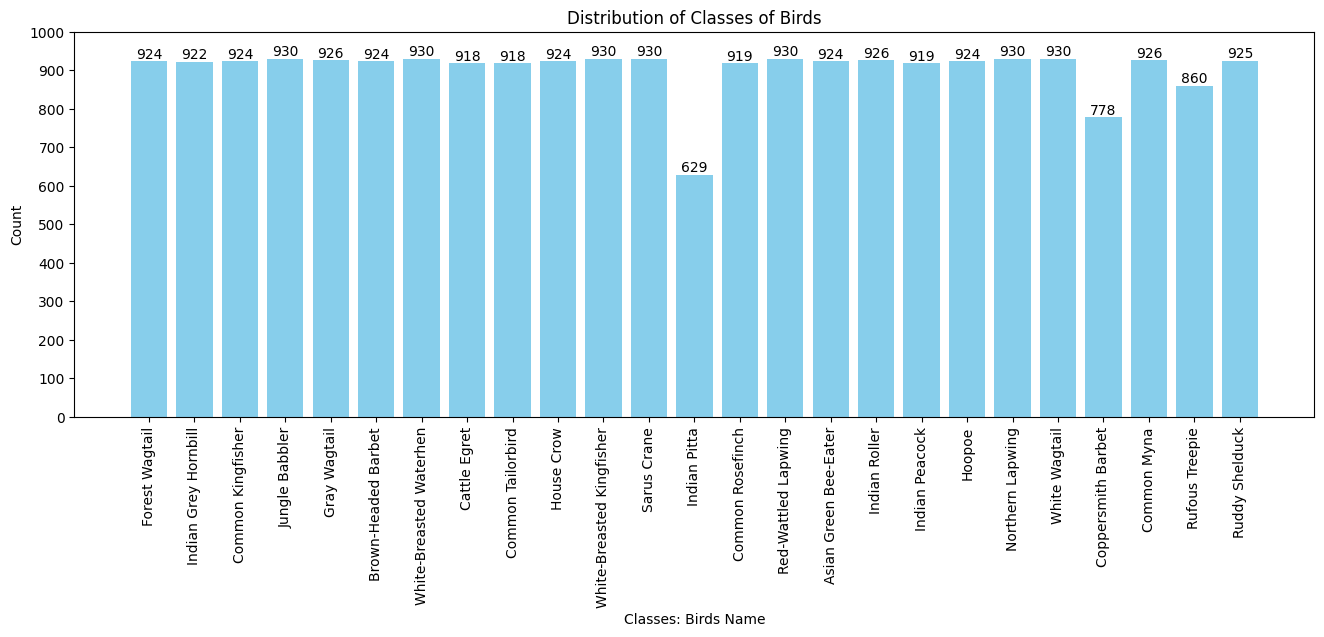

In [6]:
# Counting the occurrences of each label/Exploring the Class Distribution 

# Define the path to the source directory
source_dir = dataset_dir

# Get a list of subdirectories (bird species) in the source directory
species_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

# Count the number of images in each species folder
label_counts = {species: len(os.listdir(os.path.join(source_dir, species))) for species in species_dirs}

# Create the bar chart
plt.figure(figsize=(16, 5))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title('Distribution of Classes of Birds')
plt.xlabel('Classes: Birds Name')
plt.ylabel('Count')

# Set y-ticks from 0 to the max count with an interval of 100
plt.yticks(range(0, max(label_counts.values()) + 100, 100))

plt.xticks(rotation=90)  # Rotate labels for better readability

# Add count labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

We see in this class distribution that apart from the classes viz. Rufous Treepie, Coppersmith Barbet & Indian Pitta, the dataset is mostly balanced

## Dataset Overview : Size of dataset and number & name of the classes

In [7]:
for i, key in enumerate(label_counts.keys(), 1):
    print(f"{i}. {key}")

1. Forest Wagtail
2. Indian Grey Hornbill
3. Common Kingfisher
4. Jungle Babbler
5. Gray Wagtail
6. Brown-Headed Barbet
7. White-Breasted Waterhen
8. Cattle Egret
9. Common Tailorbird
10. House Crow
11. White-Breasted Kingfisher
12. Sarus Crane
13. Indian Pitta
14. Common Rosefinch
15. Red-Wattled Lapwing
16. Asian Green Bee-Eater
17. Indian Roller
18. Indian Peacock
19. Hoopoe
20. Northern Lapwing
21. White Wagtail
22. Coppersmith Barbet
23. Common Myna
24. Rufous Treepie
25. Ruddy Shelduck


In [8]:
total_images = sum(label_counts.values())
print(f"Total images: {total_images}")

Total images: 22620


So we can see that there are total 22620 iamges in the dataset ditributed across 25 categories/classes of birds

## Dataset overview: Checking for corrupt files

In [9]:
#  Checking for corrupt files in the dataset
from PIL import Image

# Function to check if an image is corrupted
def check_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verifies if the image is not corrupted
        return True
    except (IOError, SyntaxError):
        return False

# Function to count images in each species subdirectory and check for corrupted files
def check_dataset_integrity(dataset_path):
    found_corruption = False  # Flag to track if any corrupted files are found
    for species_dir in os.listdir(dataset_path):
        species_path = os.path.join(dataset_path, species_dir)
        
        if os.path.isdir(species_path):  # Only process directories
            corrupted_files = 0  # Reset corrupted files count for each species
            image_files = [f for f in os.listdir(species_path) if os.path.isfile(os.path.join(species_path, f))]
            
            # Check for corrupted images
            for image_file in image_files:
                image_path = os.path.join(species_path, image_file)
                if not check_image(image_path):
                    corrupted_files += 1  # Increment count for corrupted file

            # If there are corrupted files, print the species and details
            if corrupted_files > 0:
                found_corruption = True
                print(f"Processing species: {species_dir}")
                print(f"Found {corrupted_files} corrupted files in '{species_dir}' directory.")
    
    # If no corrupted files were found
    if not found_corruption:
        print("No corrupted files found for any of the classes/species.")

# Call the function to check the dataset
check_dataset_integrity(dataset_dir)

No corrupted files found for any of the classes/species.


We can see that there is no corrupt image files in the dataset.

## Dataset overview: Analyzing file formats in the dataset

In [10]:
# checking file format inconsistencies

import imghdr
global_inconsistant_files = [] # for removal of these files later

# function for checking inconsistant file formats in the dataset
def check_file_types(directory):
    valid_formats = {'jpeg', 'jpg', 'png'} #safe to be complied with ImageNet dataset image formats
    inconsistent_files = []

    for root, _, files in os.walk(directory): # since we are not using the dirs (lsit of subdirectories), we place a underscore '_'
        for file in files:
            file_path = os.path.join(root, file)
            file_type = imghdr.what(file_path)
                                  
            if file_type not in valid_formats:
                # Capture the relative path of the file
                relative_path = os.path.relpath(file_path, directory)
                inconsistent_files.append((relative_path, file_type))
                    
    if inconsistent_files:
        print("Inconsistent files found:")
        for file, file_type in inconsistent_files:
            global_inconsistant_files.append(dataset_dir+'/'+file)
            print(f"{file}: {file_type}")
    else:
        print("All files have consistent formats.")

# Run the function
check_file_types(dataset_dir)

Inconsistent files found:
Sarus Crane/ML113680271.jpg: gif
Red-Wattled Lapwing/ML48543381.jpg: gif
Ruddy Shelduck/ML220226881.jpg: gif


We can see that these 3 image files are actually gifs but are extensioned as jpg files. We shall try to convert these later into jpeg files in the data cleaning section.

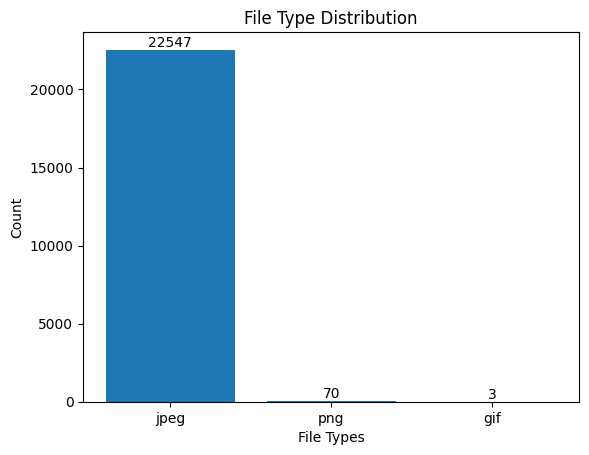

In [11]:
# visualizing the file format/type distributions across the dataset
from collections import Counter
# function to get file types/formats
def get_file_types(directory):
    file_types = []

    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_type = imghdr.what(file_path)
            if file_type:
                file_types.append(file_type)
    
    return Counter(file_types)

# Get file types and plot
file_type_counts = get_file_types(dataset_dir)

# Create the bar plot
plt.bar(file_type_counts.keys(), file_type_counts.values())

# Add counts on top of the bars
for i, count in enumerate(file_type_counts.values()):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

# Add labels and title
plt.title("File Type Distribution")
plt.xlabel("File Types")
plt.ylabel("Count")
plt.show()

We can see that almost all of the dataset has jpeg images; only 70 png images are there and the 3 gif shall be converted to jpeg.

## Dataset overview: Checking for duplicate image files across the classes in the dataset

In [12]:
# checking for duplicate images
import hashlib
global_list_for_duplicate =[] # for dupliacte removal later
# function to cal
def calculate_hash(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest() #Calculate the MD5 hash of a file.

# Directory containing images
image_dir = dataset_dir
hashes = {}
duplicate_sets = []  # To store sets of duplicate files

for root, _, files in os.walk(image_dir):
    for file in files:
        file_path = os.path.join(root, file)
        file_hash = calculate_hash(file_path)

        if file_hash in hashes:
            global_list_for_duplicate.append(hashes[file_hash])
            print(f"Duplicate found: {file_path} and {hashes[file_hash]}")
            
            # Add duplicate set if not already added
            if file_hash not in duplicate_sets:
                duplicate_sets.append(file_hash)
        else:
            hashes[file_hash] = file_path

# Summary of duplicate sets found
print(f"\nTotal number of duplicate sets found: {len(duplicate_sets)}")

Duplicate found: dataset/training_set/Forest Wagtail/ML354730631.jpg and dataset/training_set/Forest Wagtail/ML221676551.jpg
Duplicate found: dataset/training_set/Forest Wagtail/ML197650521.jpg and dataset/training_set/Forest Wagtail/ML195014971.jpg
Duplicate found: dataset/training_set/Forest Wagtail/ML43455441.jpg and dataset/training_set/Forest Wagtail/ML42324851.jpg
Duplicate found: dataset/training_set/Forest Wagtail/ML57265451.jpg and dataset/training_set/Forest Wagtail/ML57265481.jpg
Duplicate found: dataset/training_set/Indian Grey Hornbill/ML205557511.jpg and dataset/training_set/Indian Grey Hornbill/ML205553121.jpg
Duplicate found: dataset/training_set/Jungle Babbler/ML192005601.jpg and dataset/training_set/Jungle Babbler/ML192005701.jpg
Duplicate found: dataset/training_set/Jungle Babbler/ML417224421.jpg and dataset/training_set/Jungle Babbler/ML417225031.jpg
Duplicate found: dataset/training_set/Jungle Babbler/ML62399541.jpg and dataset/training_set/Jungle Babbler/ML7721628

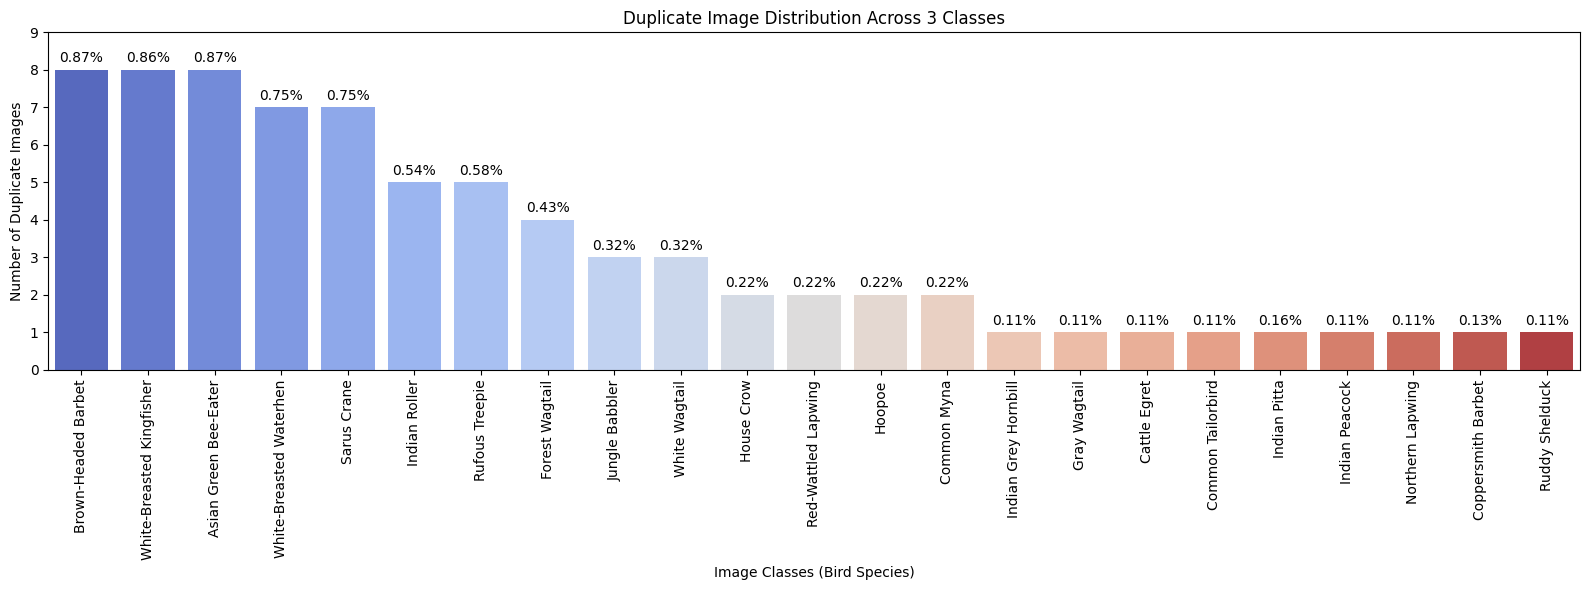

In [13]:
# Visualizing the duplicates across the image classes with percentange of duplicate images relative to its class
from collections import defaultdict

# Function to calculate MD5 hash
def calculate_hash(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Directory containing images
image_dir = dataset_dir

hashes = {}
duplicates_by_class = defaultdict(int)
total_images_by_class = defaultdict(int)

# Walk through the image directory
for root, _, files in os.walk(image_dir):
    for file in files:
        file_path = os.path.join(root, file)
        class_name = os.path.basename(os.path.dirname(file_path))  # Extract class name

        # Count total images for each class
        total_images_by_class[class_name] += 1

        # Calculate hash and detect duplicates
        file_hash = calculate_hash(file_path)
        if file_hash in hashes:
            duplicates_by_class[class_name] += 1
        else:
            hashes[file_hash] = file_path

# Keep only classes with more than one duplicate image
duplicate_classes = {cls: count for cls, count in duplicates_by_class.items() if count ==8}

# Convert to a sorted list for visualization
duplicate_counts = sorted(duplicates_by_class.items(), key=lambda x: x[1], reverse=True)

# Extract class names and counts for plotting
classes = [x[0] for x in duplicate_counts]
duplicate_counts_values = [x[1] for x in duplicate_counts]

# Calculate percentage of duplicates for each class relative to the class
percentages = [
    (duplicates_by_class[cls] / total_images_by_class[cls]) * 100 if total_images_by_class[cls] > 0 else 0
    for cls in classes
]

# Plotting the distribution of duplicate images
plt.figure(figsize=(16, 6))
sns.barplot(x=classes, y=duplicate_counts_values, palette="coolwarm")
plt.xticks(rotation=90)
plt.yticks(range(0, 10, 1))  # Set Y-axis ticks from 0 to 9 with an interval of 1
plt.xlabel('Image Classes (Bird Species)')
plt.ylabel('Number of Duplicate Images')
plt.title(f'Duplicate Image Distribution Across {len(duplicate_classes)} Classes')

# Annotate each bar with percentage
for i, (count, percentage) in enumerate(zip(duplicate_counts_values, percentages)):
    plt.text(i, count + 0.2, f'{percentage:.2f}%', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

So we can see that 75 images in the dataset across 23 have more than one occurance.These duplicate records shall be weed out keeping only one occurance of the image.

## Visual Inspection of the dataset: Display random image from each class/species

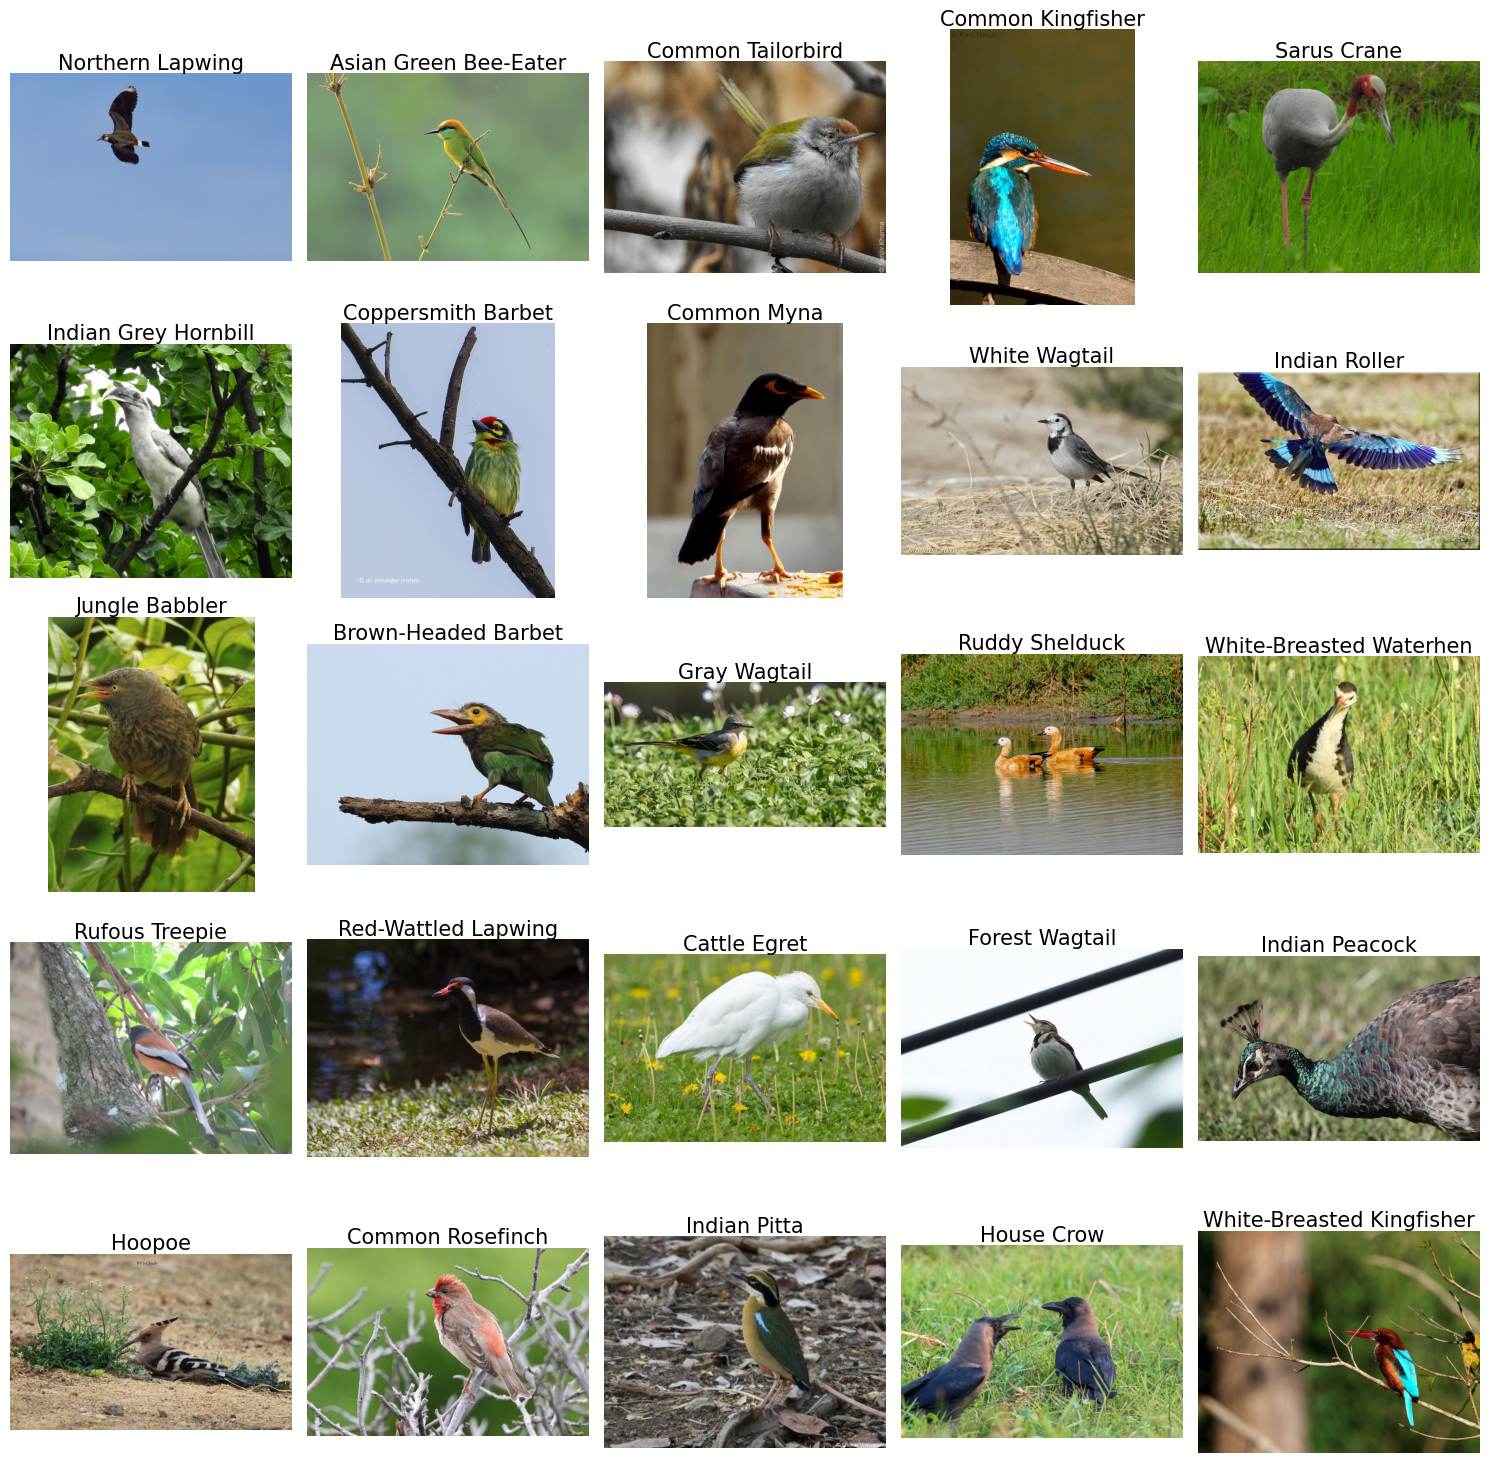

In [14]:
# Display random image from each class/species
def visualize_images(dataset_dir, rows=5, cols=5):
    # Get the list of bird species subdirectories
    species_dirs = [os.path.join(dataset_dir, species) for species in os.listdir(dataset_dir) if
                    os.path.isdir(os.path.join(dataset_dir, species))]

    # Select the 25 species (one for each grid slot)
    selected_species = random.sample(species_dirs, rows * cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flatten()):
        # Pick a random image from the selected species
        species_dir = selected_species[i]
        image_path = random.choice([os.path.join(species_dir, img) for img in os.listdir(species_dir) if img.
                                    endswith(('.jpg', '.jpeg', '.png'))])

        # Open the image
        img = Image.open(image_path)

        # Display the image
        ax.imshow(img)
        ax.axis('off')

        # Add label (species name) below the image
        species_name = os.path.basename(species_dir)  # Get the name of the species (directory name)
        ax.set_title(species_name, fontsize=15, verticalalignment='center', horizontalalignment='center')

    plt.tight_layout()
    plt.show()

# calling the displaying function
visualize_images(dataset_dir)

We can see one random image from each bird species/class in the grid above which appears correctly as per their label

## Visual Inspection of the dataset: Assessing the quality of the image - Checking for blank images in the dataset

In [15]:
# checking for blank images
def check_blank_images(dataset_dir):
    species_dirs = [os.path.join(dataset_dir, species) for species in os.listdir(dataset_dir) if 
                    os.path.isdir(os.path.join(dataset_dir, species))]
    
    blank_images_found = False  # Flag to track if any blank images are found

    # Iterate over each species directory and each image within it
    for species_dir in species_dirs:
        blank_in_species = False  # Flag to track if blank images are found in this species directory
        for img_name in os.listdir(species_dir):
            img_path = os.path.join(species_dir, img_name)
            try:
                img = Image.open(img_path)
                if img.size == (0, 0):  # Check if the image is blank
                    print(f"Blank image found in {species_dir} class: {img_path}")
                    blank_in_species = True
            except (IOError, SyntaxError):
                continue  # Skip corrupted images, as they are not being checked in this case

        if blank_in_species:
            blank_images_found = True  # Mark that blank images were found

    # Notify if no blank images were found in any species directory
    if not blank_images_found:
        print("No blank images found in the entire dataset.")

# calling the check function
check_blank_images(dataset_dir)

No blank images found in the entire dataset.


We can see that there is no blank in the entire dataset which is a good thing for the model training.

## Visual Inspection of the dataset: Assessing the quality of the image - Checking for blurry images in the dataset

In [16]:
# checking for blurry image
from PIL import ImageFilter
# function to check if an image is blurry using the variance of the Laplacian method
# variance threshold is calculated below which the image is considered blurry.
blurry_images = []  # Store paths of blurry images

def check_blurry_image(image_path, threshold=100): #100 is used as it seems to be thestandard value of threshold used widely for blurry image
    
    try:
        # Open the image and convert it to grayscale
        img = Image.open(image_path).convert("L")

        # Apply Laplacian filter to detect edges
        laplacian = img.filter(ImageFilter.FIND_EDGES)

        # Convert the filtered image to a NumPy array
        laplacian_array = np.array(laplacian)

        # Calculate the variance of the Laplacian
        variance = laplacian_array.var()
       
        # Check if the variance is below the threshold
        return variance < threshold
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return False


# function to check all images in the dataset directory for blurry images:
def check_blurry_images_in_dataset(dataset_dir, threshold=100):
    species_dirs = [os.path.join(dataset_dir, species) for species in os.listdir(dataset_dir) if
                    os.path.isdir(os.path.join(dataset_dir, species))]
    
    for species_dir in species_dirs:
        for img_name in os.listdir(species_dir):
            img_path = os.path.join(species_dir, img_name)
            if check_blurry_image(img_path, threshold):
                blurry_images.append(img_path)
                print(f"Blurry image detected: {img_path}")
    
    if not blurry_images:
        print("No blurry images found in the dataset.")
    else:
        print(f"Total blurry images found: {len(blurry_images)}")

# calling the above 
check_blurry_images_in_dataset(dataset_dir)

Blurry image detected: dataset/training_set/Forest Wagtail/ML218388861.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML123336751.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML285704321.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML290680051.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML272852671.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML321207471.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML212896701.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML388196691.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML498957741.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML388196041.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML370662331.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML218388741.jpg
Blurry image detected: dataset/training_set/Indian Grey Hornbill/ML208792181.jpg
Blurry image detect

Alright, this took too long to process!! I always wanted to try concurrency functionalities in Python. The following is a re-writng of the above snippet with exact functionalites but with concurrent execution on all the available cores (I have 12vCPU cores). Let's run this!

In [17]:
# checking for blurry image with concurrent execution using all CPU cores
from concurrent.futures import ThreadPoolExecutor, as_completed
# function to check if an image is blurry using the variance of the Laplacian method
# variance threshold is calculated below which the image is considered blurry.
blurry_images = []  # Store paths of blurry images

def check_blurry_image(image_path, threshold=100): #100 is used as it seems to be thestandard value of threshold used widely for blurry image
    try:
        # Open the image and convert it to grayscale
        img = Image.open(image_path).convert("L")

        # Apply Laplacian filter to detect edges
        laplacian = img.filter(ImageFilter.FIND_EDGES)

        # Convert the filtered image to a NumPy array
        laplacian_array = np.array(laplacian)

        # Calculate the variance of the Laplacian
        variance = laplacian_array.var()
       
        # Check if the variance is below the threshold
        return image_path, variance < threshold
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return image_path, False

# Function to check all images in the dataset directory for blurry images in parallel
def check_blurry_images_in_dataset(dataset_dir, threshold=100):
    species_dirs = [os.path.join(dataset_dir, species) for species in os.listdir(dataset_dir) if 
                    os.path.isdir(os.path.join(dataset_dir, species))]

    with ThreadPoolExecutor() as executor:
        futures = []
        for species_dir in species_dirs:
            for img_name in os.listdir(species_dir):
                img_path = os.path.join(species_dir, img_name)
                futures.append(executor.submit(check_blurry_image, img_path, threshold))
        
        for future in as_completed(futures):
            img_path, is_blurry = future.result()
            if is_blurry:
                blurry_images.append(img_path)
                print(f"Blurry image detected: {img_path}")
    
    if not blurry_images:
        print("No blurry images found in the dataset.")
    else:
        print(f"Total blurry images found: {len(blurry_images)}")

# Calling the function
check_blurry_images_in_dataset(dataset_dir)

Blurry image detected: dataset/training_set/Forest Wagtail/ML218388861.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML285704321.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML290680051.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML123336751.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML272852671.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML321207471.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML212896701.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML388196691.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML498957741.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML388196041.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML370662331.jpg
Blurry image detected: dataset/training_set/Forest Wagtail/ML218388741.jpg
Blurry image detected: dataset/training_set/Indian Grey Hornbill/ML208792181.jpg
Blurry image detect

Worked 5 times faster!

We can see that that appears to be 105 images that are identified as blurry. I checked some samples manually and found that a few are identified blurry due to inteded bokeh. But to be on the safe side, and since the number of identified images is not more than 12 in any class, I shall anyways remove these images before training so that dataset has good quality images for getting better scores/accuracy in model training.

Let us now do a bar plot visualization the identified blurry images across the classes

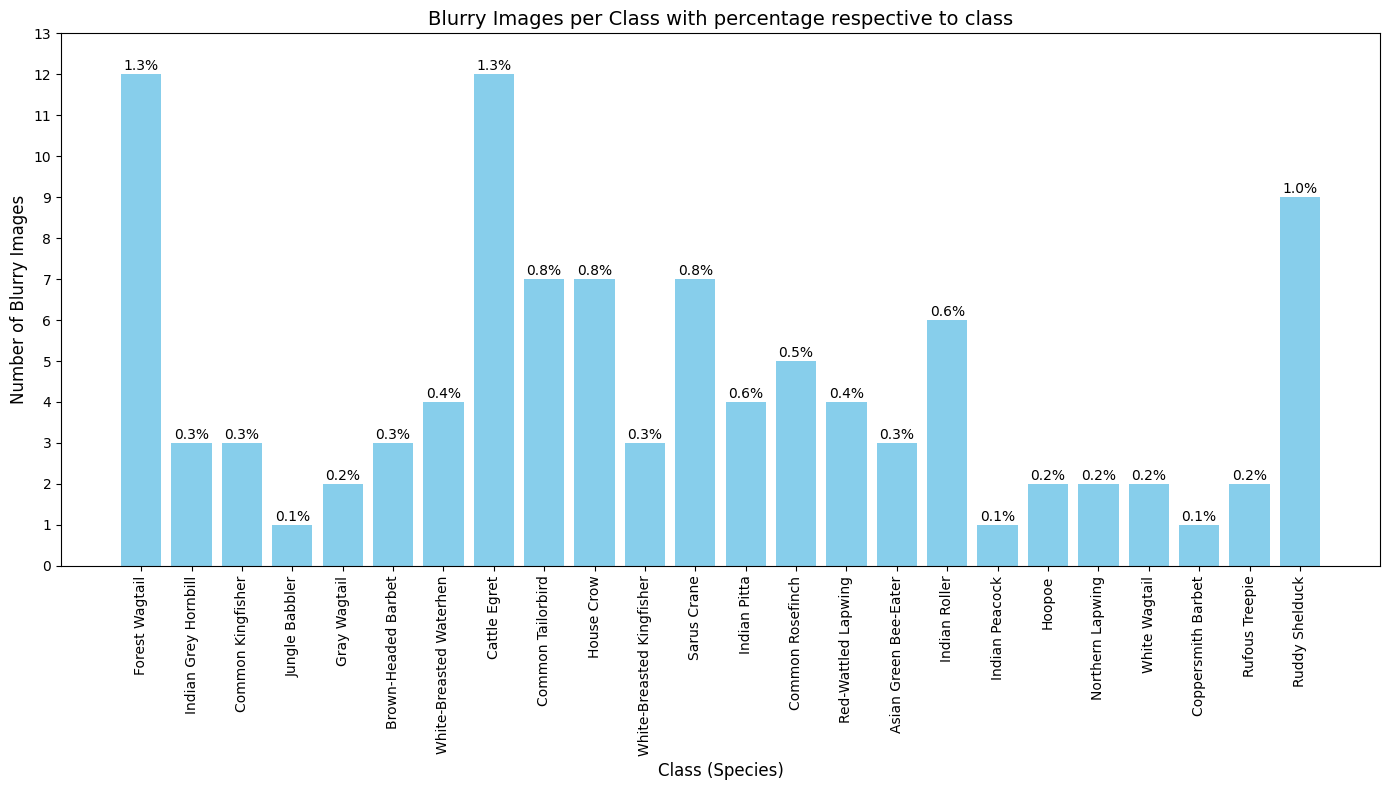

In [18]:
# function to bar plot the identified blurry images across the classes
def plot_blurry_images_per_class(blurry_images, dataset_dir):
    # Extract class names (species) from the blurry images paths
    class_names = [os.path.basename(os.path.dirname(img)) for img in blurry_images]

    # Count occurrences of blurry images per class
    class_counts = Counter(class_names)

    # Get total number of images per class (species) in the dataset
    species_dirs = [os.path.join(dataset_dir, species) for species in os.listdir(dataset_dir) if
                    os.path.isdir(os.path.join(dataset_dir, species))]
    total_images_per_class = {
        os.path.basename(species_dir): len([img for img in os.listdir(species_dir) if img.endswith(('.jpg', '.jpeg', '.png'))])
        for species_dir in species_dirs
    }

    # Create a bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

    # Add labels and title
    plt.xlabel('Class (Species)', fontsize=12)
    plt.ylabel('Number of Blurry Images', fontsize=12)
    plt.yticks(range(0, 14, 1))  # Set Y-axis ticks from 0 to 9 with an interval of 1
    plt.title('Blurry Images per Class with percentage respective to class', fontsize=14)
    plt.xticks(rotation=90)
    
    # Annotate bars with percentage
    for bar in bars:
        height = bar.get_height()
        species_name = bar.get_x() + bar.get_width() / 2
        # Get the corresponding species from class_counts (bar x position to class)
        species = list(class_counts.keys())[int(species_name)] 
        total_images = total_images_per_class.get(species, 0)
        if total_images > 0:
            percentage = (height / total_images) * 100
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{percentage:.1f}%', ha='center', fontsize=10)
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, '0%', ha='center', fontsize=10)

    plt.tight_layout()

    # Display the plot
    plt.show()

# calling the function
plot_blurry_images_per_class(blurry_images, dataset_dir)

## Visual Inspection of the dataset: Checking orientation of images in the dataset

The orientation of images in a dataset can significantly impact the performance and training process of a Convolutional Neural Network(CNN). Inconsistent Orientation Can confuse the CNN and lead to poor performance and misclassification.

In [19]:
# checking the image dataset for incorrectly oriented images
from PIL import ExifTags
# function to check the orientation of a single image (we are usng concurrent execution using all CPU cores here too!)
def check_orientation_for_image(file_path, orientation_tags):
    try:
        # Open image and get EXIF data
        img = Image.open(file_path)
        exif = img._getexif()

        if exif is not None:
            # Search for the orientation tag (tag 274 for )
            for tag, value in exif.items():
                if tag == 274:  # Orientation tag
                    orientation = orientation_tags.get(value, "Unknown orientation")
                    if value != 1:  # If not normal orientation (1)
                        return file_path, orientation
        return None  # No incorrect orientation or no EXIF data
    except (AttributeError, KeyError, IndexError):
        # Handle errors in case there's no EXIF data
        return None

# function to iterate through all images in the directory and check their image orientation
def check_image_orientation(directory):
    # Map of EXIF orientation tags
    orientation_tags = {
        1: "Normal",
        3: "Upside down (180°)",
        6: "Rotated 90° clockwise",
        8: "Rotated 90° counterclockwise"
    }

    incorrect_orientation = []  # List to store images with incorrect orientation

    # List of image paths to check
    image_paths = []
    
    # Collect image paths in the directory
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            image_paths.append(file_path)

    # Use ThreadPoolExecutor to process images concurrently
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(check_orientation_for_image, file_path, orientation_tags) for file_path in image_paths]
        
        # Collect results as they are completed
        for future in as_completed(futures):
            result = future.result()
            if result:
                incorrect_orientation.append(result)

    # Print out images with incorrect orientation
    if incorrect_orientation:
        print("Images with incorrect orientation:")
        for image_path, orientation in incorrect_orientation:
            print(f"{image_path}: {orientation}")
    else:
        print("All images have correct orientation (or no EXIF data).")

# Run the function to check orientation
check_image_orientation(dataset_dir)

Images with incorrect orientation:
dataset/training_set/Rufous Treepie/ML25193321.jpg: Rotated 90° counterclockwise


We can see that only one image in the entire dataset has incorrect orientation according to EXIF data. We shall just remove the image.

## Image Property Analysis: checking image dimensions across the bird species/classes

In [20]:
# checking image dimensions across the bird species/classes and 
# calculate mean dimension and standard deviation

# Collect all image paths
image_paths_this = [
    os.path.join(root, file)
    for root, _, files in os.walk(dataset_dir)
    for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Get dimensions for each image
dimensions = []
for img_path in image_paths_this:
    with Image.open(img_path) as img:
        dimensions.append(img.size)  # Width, Height

# Convert to a NumPy array and calculate mean and standard deviation
dimensions = np.array(dimensions)
mean_dimensions = np.mean(dimensions, axis=0)
std_dev_dimensions = np.std(dimensions, axis=0)

# Print the results
print(f"Total images: {len(image_paths_this)}")
print(f"Mean dimensions: {mean_dimensions}, Std Dev: {std_dev_dimensions}")

Total images: 22620
Mean dimensions: [1143.22276746  852.30570292], Std Dev: [139.24390696 152.55454578]


Let us plot the min, max and mean image dimensions in a class for the dataset

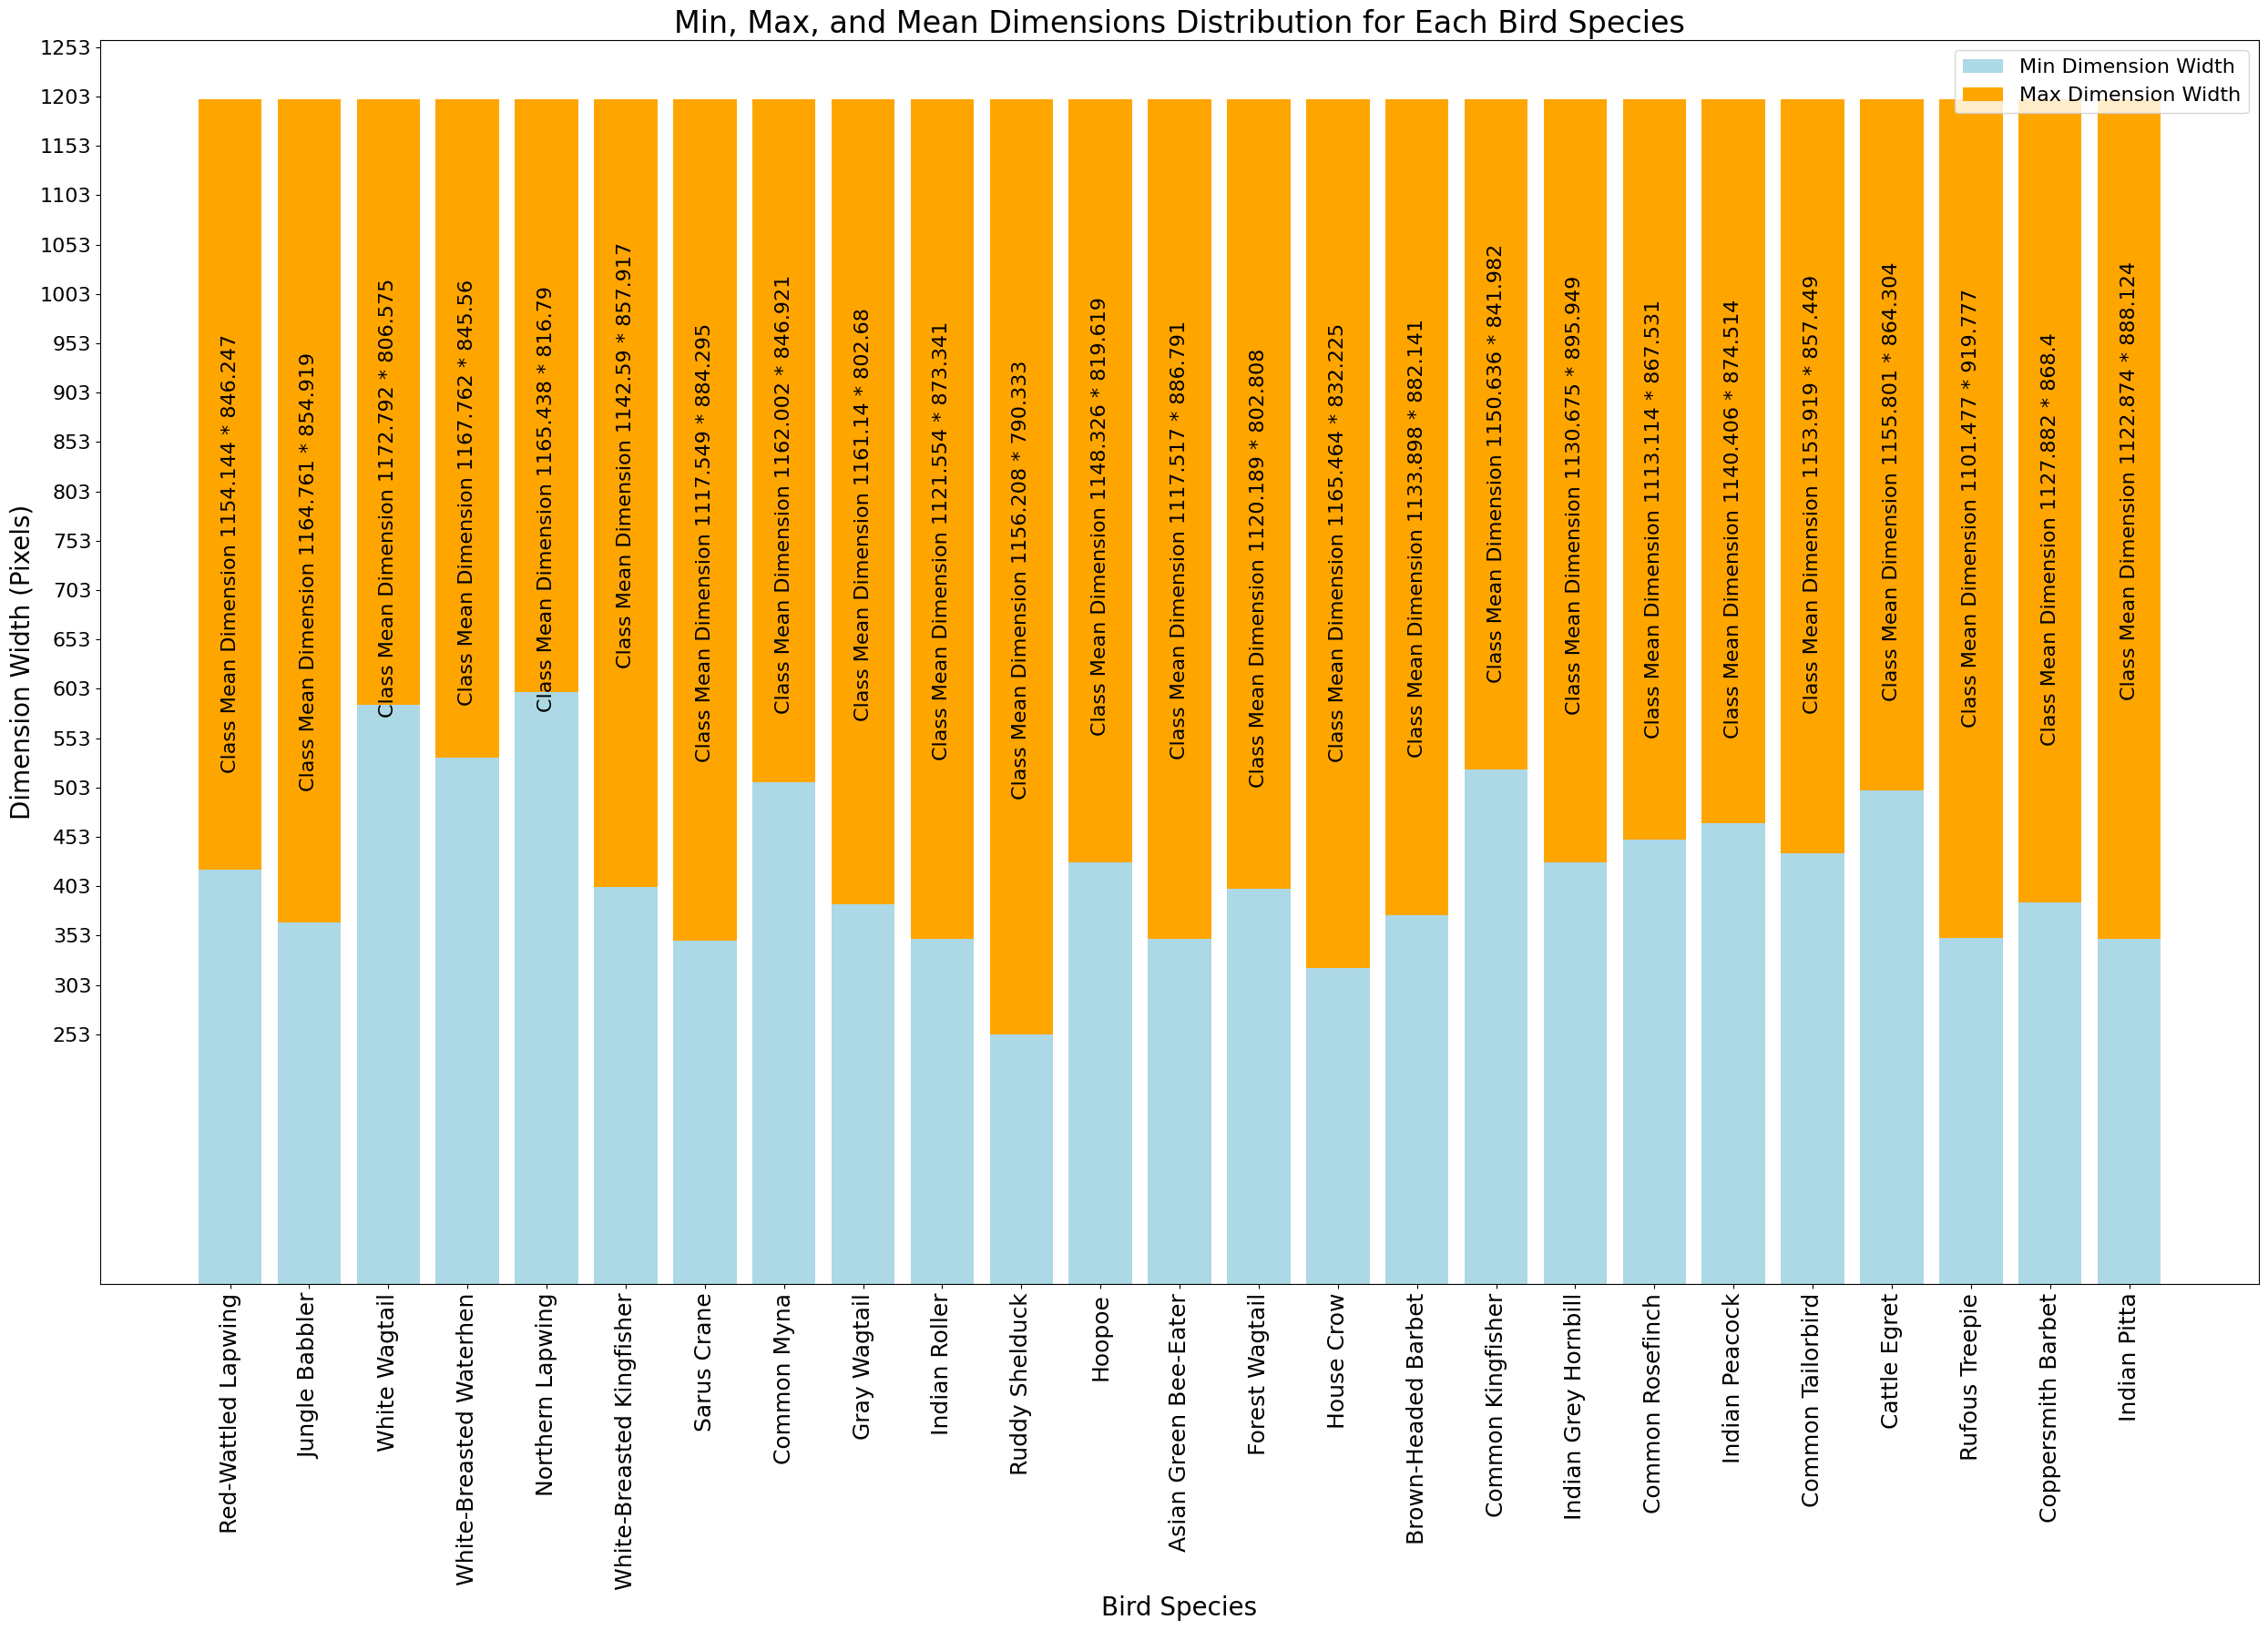

In [21]:
# plotting the min, max and mean image dimensions in a class for the dataset

# Get the species from the paths (assuming the folder name is the species name)
species_names = [os.path.basename(os.path.dirname(img_path)) for img_path in image_paths_this]

# Count the number of images per species
species_counts = pd.Series(species_names).value_counts()

# Initialize dictionary to store min, max, mean dimensions for each species
species_dimensions = {}

# Loop through each species to get min, max, and mean dimensions
for species in species_counts.index:
    # Get the image paths for the current species
    species_image_paths = [img_path for img_path in image_paths_this if os.path.basename(os.path.dirname(img_path)) == species]
    
    # Get the indices for the current species images
    species_indices = [image_paths_this.index(img_path) for img_path in species_image_paths]
    
    # Extract dimensions for the current species from the overall dimensions array
    species_dimensions_list = dimensions[species_indices]
    
    # Calculate min, max, and mean dimensions for each species
    min_dim = species_dimensions_list.min(axis=0)
    max_dim = species_dimensions_list.max(axis=0)
    #print('species ', species, 'min dim ', min_dim, 'max_dim ', max_dim)
    # Calculate mean dimensions for the species (width * height format)
    mean_dim = np.mean(species_dimensions_list, axis=0)
    
    # Store the results in the dictionary
    species_dimensions[species] = {
        'min': min_dim,
        'max': max_dim,
        'mean': mean_dim
    }

# Plotting
plt.figure(figsize=(25, 18))  # Increased figure size to accommodate more y-ticks

# Set positions for bars
x_pos = np.arange(len(species_dimensions))

# Plot each species with two segments for min and max dimensions
for i, (species, dims) in enumerate(species_dimensions.items()):
    # Extract min, max, and mean dimensions
    min_width, min_height = dims['min']
    max_width, max_height = dims['max']
    mean_width, mean_height = dims['mean']
    
    # Bar for the species (min and max)
    plt.bar(x_pos[i], min_width, color='lightblue', label='Min Dimension Width' if i == 0 else "")
    plt.bar(x_pos[i], max_width - min_width, bottom=min_width, color='orange', label='Max Dimension Width' if i == 0 else "")
    
    # Display the mean dimension in the format mean_width * mean_height on the bar
    plt.text(x_pos[i], (min_height + max_height)/ 2, f"Class Mean Dimension {round(mean_width, 3)} * {round(mean_height, 3)}",
             ha='center', va='center', fontsize=16, rotation=90)

# Customize the plot
plt.xticks(x_pos, species_dimensions.keys(), rotation=90, fontsize=18)
plt.ylabel("Dimension Width (Pixels)", fontsize=20)
plt.xlabel("Bird Species", fontsize=20)
plt.title("Min, Max, and Mean Dimensions Distribution for Each Bird Species", fontsize=24)
plt.legend(fontsize=16)

# Get unique widths for y-ticks (you only want to focus on the width dimension)
unique_widths = sorted(set(dims['min'][0] for dims in species_dimensions.values()) |
                       set(dims['max'][0] for dims in species_dimensions.values()))

# Set the range for y-ticks from 0 to max_width + 10, with intervals of 10
ytick_positions = np.arange(min(unique_widths), max(unique_widths) + 100, 50)

# Format y-ticks as just width values
ytick_labels = [str(y) for y in ytick_positions]  # Only width, no need to multiply by height

plt.yticks(ytick_positions, labels=ytick_labels, fontsize=16)

# Set font size for y-tick values
plt.tick_params(axis='y', labelsize=16)

# Tight layout
plt.tight_layout()
plt.show()

We can see that there are some image dimension imbalance across the classes with maximum image width remaining almost same for all the clasees but with some variance in minimum image width

## Image Property Analysis: checking image aspect ratios across the bird species/classes

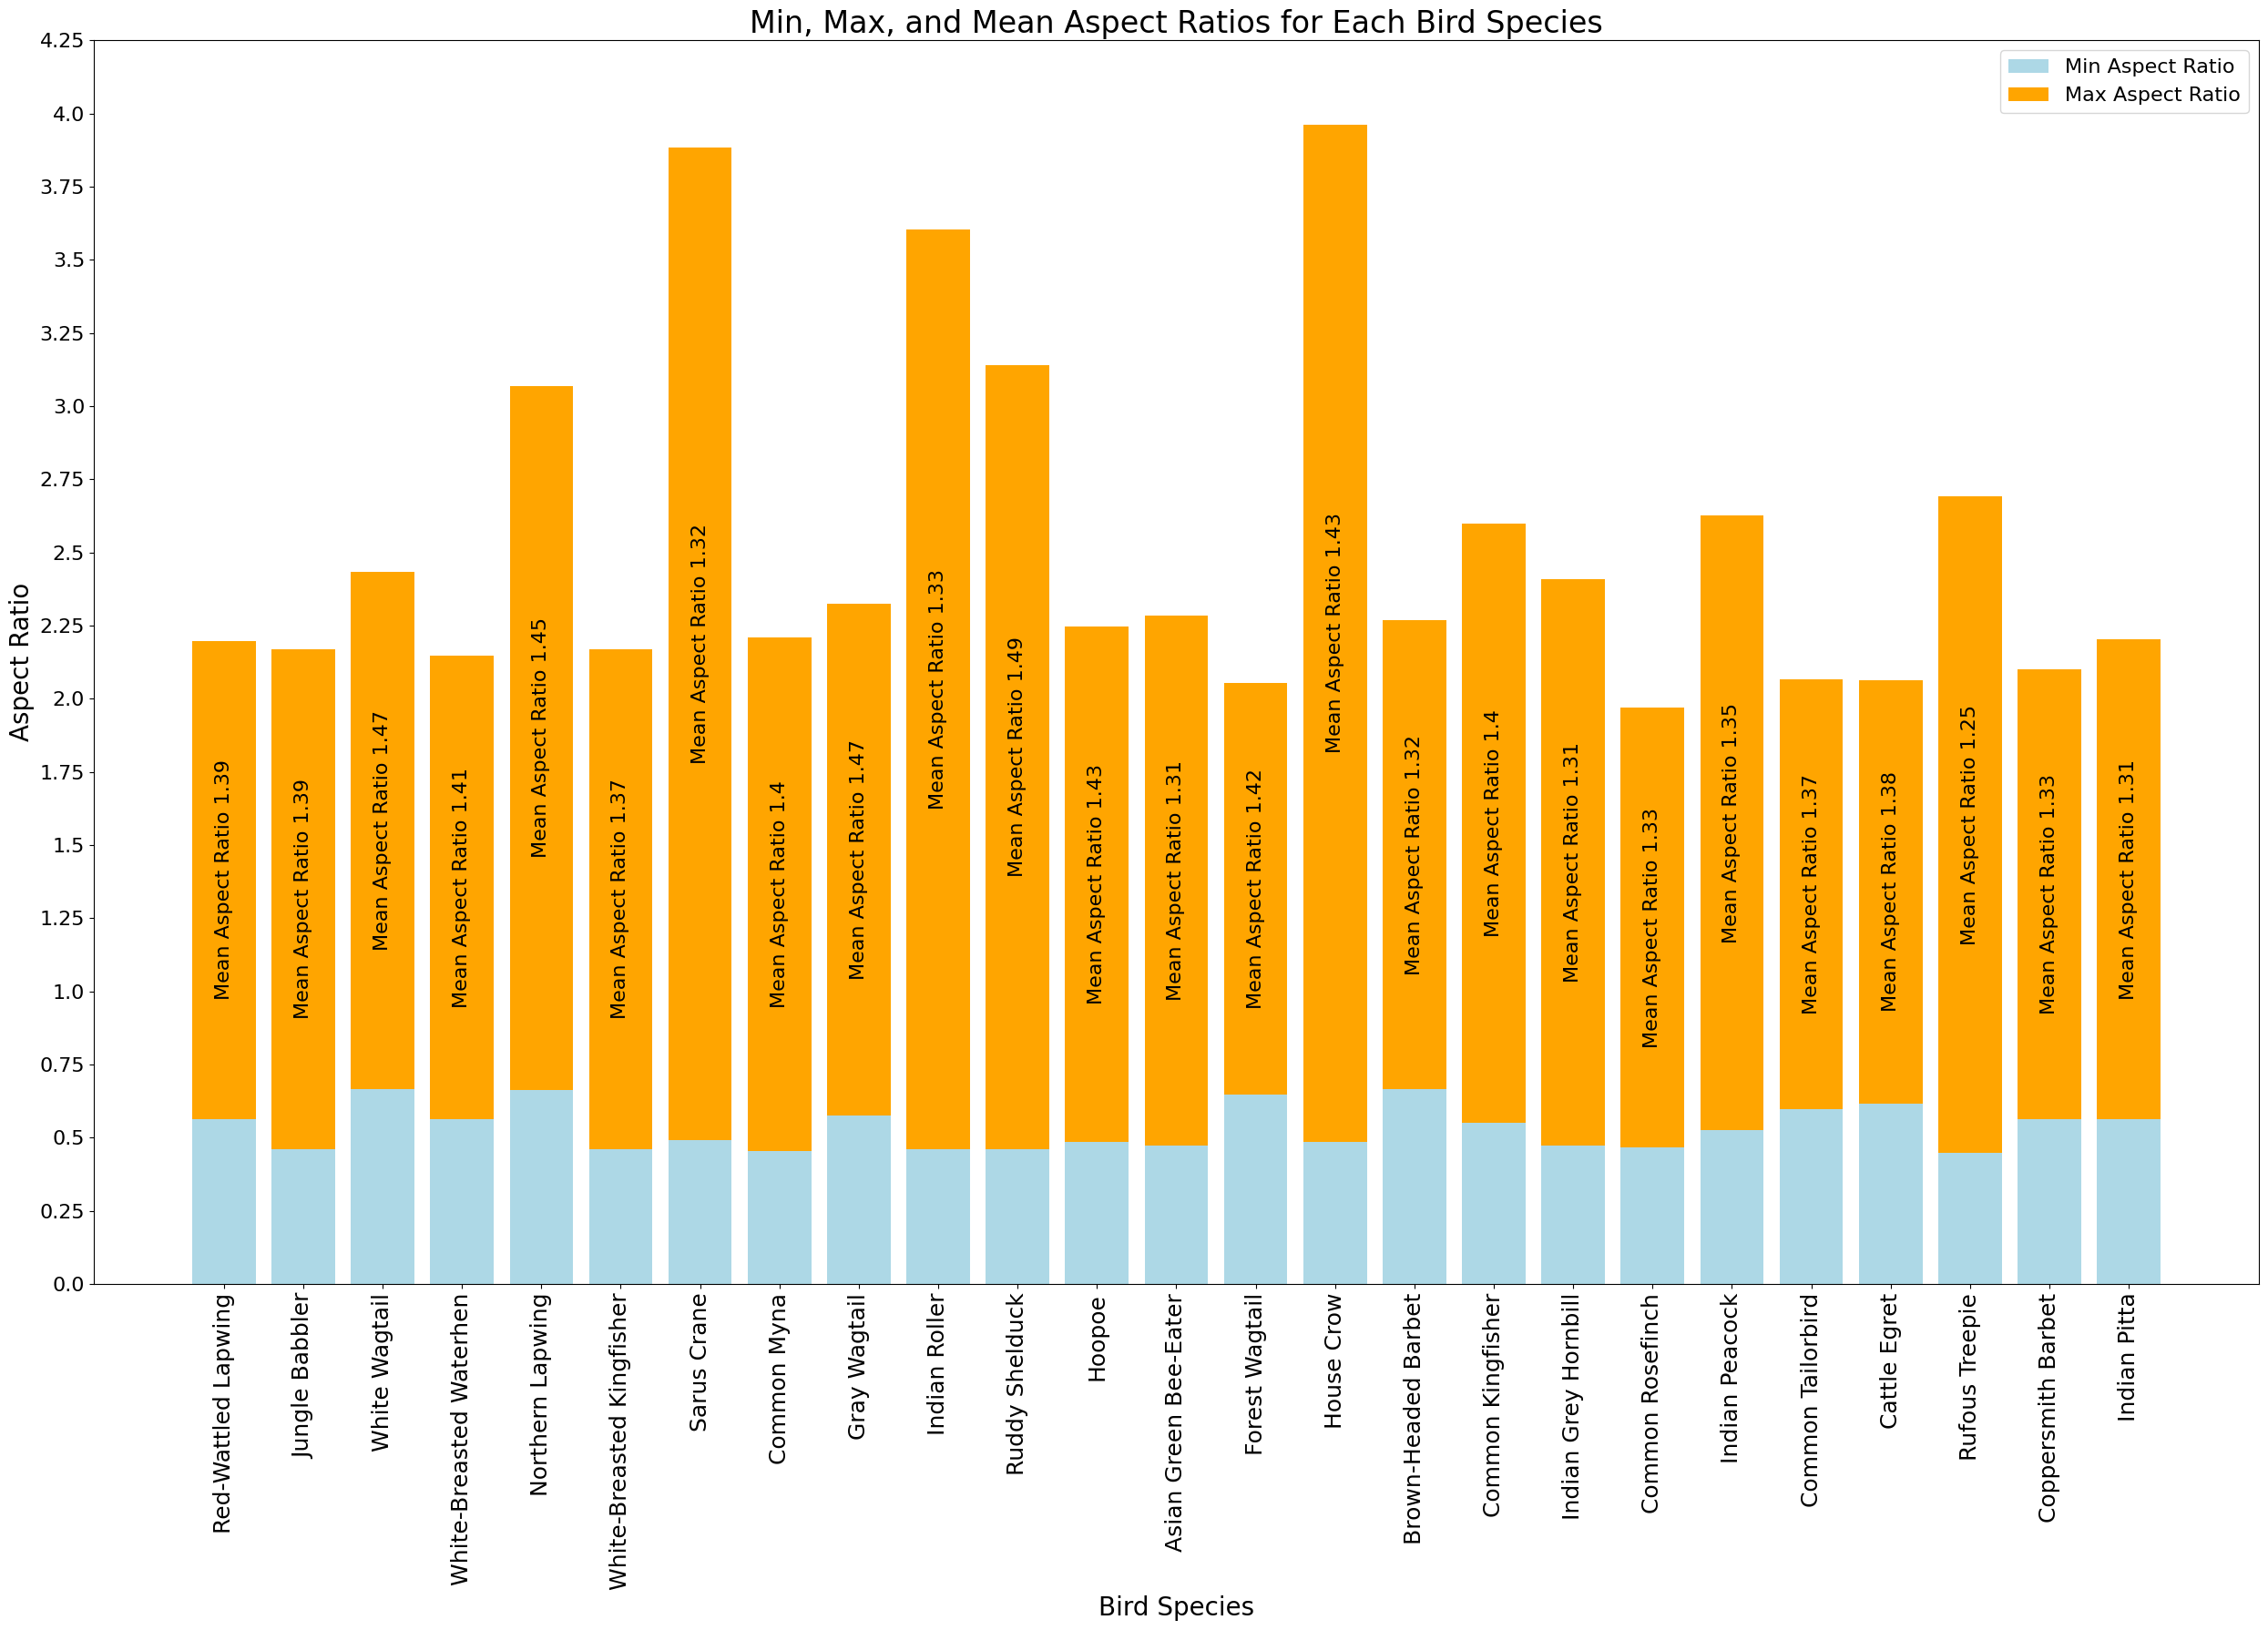

In [22]:
# aspect ratio analysis of images in the dataset and plotting of the same

# Get the species from the paths (assuming the folder name is the species name)
species_names = [os.path.basename(os.path.dirname(img_path)) for img_path in image_paths_this]

# Count the number of images per species
species_counts = pd.Series(species_names).value_counts()

# Initialize dictionary to store min, max, mean aspect ratios for each species
species_aspect_ratios = {}

# Loop through each species to get min, max, and mean aspect ratios
for species in species_counts.index:
    # Get the image paths for the current species
    species_image_paths = [img_path for img_path in image_paths_this if os.path.basename(os.path.dirname(img_path)) == species]
    
    # List to store aspect ratios for the current species
    aspect_ratios = []
    
    # Loop through each image and calculate aspect ratio (width / height)
    for img_path in species_image_paths:
        # Open image and get its dimensions
        with Image.open(img_path) as img:
            width, height = img.size
            aspect_ratio = width / height  # Aspect ratio is width divided by height
            aspect_ratios.append(aspect_ratio)
    
    # Calculate min, max, and mean aspect ratios for the species
    min_aspect_ratio = min(aspect_ratios)
    max_aspect_ratio = max(aspect_ratios)
    mean_aspect_ratio = np.mean(aspect_ratios)
    
    # Store the results in the dictionary
    species_aspect_ratios[species] = {
        'min': min_aspect_ratio,
        'max': max_aspect_ratio,
        'mean': mean_aspect_ratio
    }

# Plotting
plt.figure(figsize=(25, 18))  # Adjust figure size

# Set positions for bars
x_pos = np.arange(len(species_aspect_ratios))

# Plot each species with three bars for min, max, and mean aspect ratios
for i, (species, ratios) in enumerate(species_aspect_ratios.items()):
    # Extract min, max, and mean aspect ratios
    min_aspect_ratio = ratios['min']
    max_aspect_ratio = ratios['max']
    mean_aspect_ratio = ratios['mean']
    
    # Bar for the species (min and max aspect ratios)
    plt.bar(x_pos[i], min_aspect_ratio, color='lightblue', label='Min Aspect Ratio' if i == 0 else "")
    plt.bar(x_pos[i], max_aspect_ratio - min_aspect_ratio, bottom=min_aspect_ratio, color='orange',
            label='Max Aspect Ratio' if i == 0 else "")
    
    # Display the mean aspect ratio on the bar
    plt.text(x_pos[i], (min_aspect_ratio + max_aspect_ratio) / 2, f"Mean Aspect Ratio {round(mean_aspect_ratio, 2)}",
             ha='center', va='center', fontsize=16, rotation=90)

# Customize the plot
plt.xticks(x_pos, species_aspect_ratios.keys(), rotation=90, fontsize=18)
plt.ylabel("Aspect Ratio", fontsize=20)
plt.xlabel("Bird Species", fontsize=20)
plt.title("Min, Max, and Mean Aspect Ratios for Each Bird Species", fontsize=24)
plt.legend(fontsize=16)

# Format y-ticks with aspect ratios
ytick_positions = np.arange(0, max(ratios['max'] for ratios in species_aspect_ratios.values()) + 0.5, 0.25)
ytick_labels = [str(round(y, 2)) for y in ytick_positions]

plt.yticks(ytick_positions, labels=ytick_labels, fontsize=16)

# Set font size for y-tick values
plt.tick_params(axis='y', labelsize=16)

# Tight layout
plt.tight_layout()
plt.show()

We can see that there are some image aspect ratio imbalance across the classes with large variance in their maximum image aspect ratio but with small variance in their minimum image aspect ratio.

## Image Property Analysis: Checking RGB channels for the images in the dataset

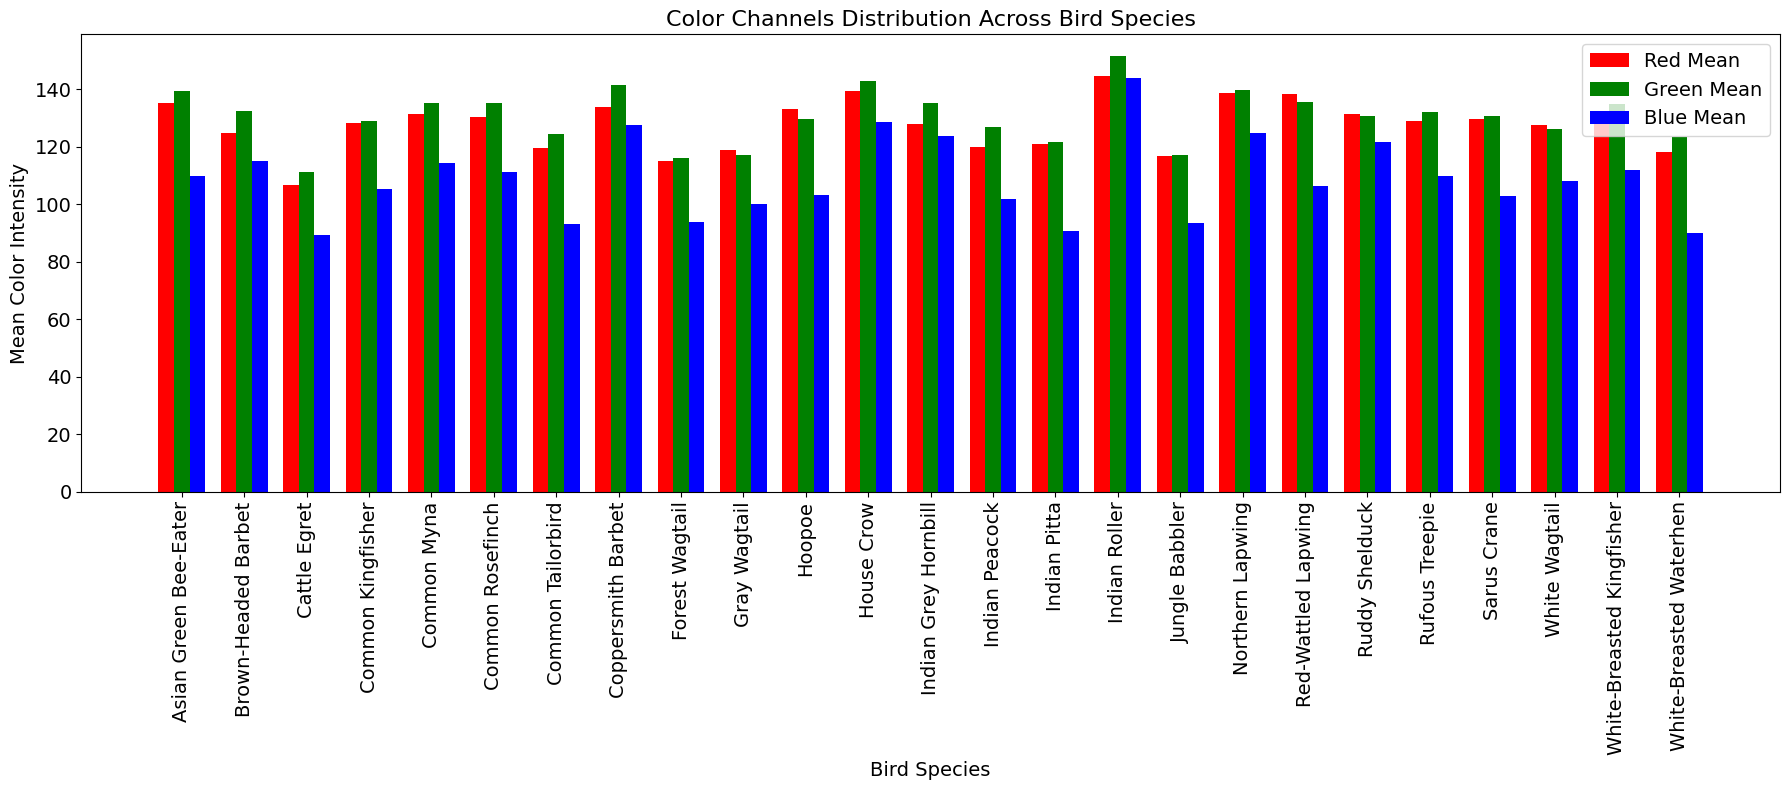

In [23]:
# checking RGB channels for the images in the dataset
# using concurrent executions here as this is a heavy task (takes too long without concurrency)
# Lists to store RGB results
color_results = []

# Function to calculate mean RGB values
def calculate_rgb_means(image_info):
    class_dir, image_file = image_info
    image_path = os.path.join(dataset_dir, class_dir, image_file)
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    
    # Calculate mean values for each channel
    red_mean = np.mean(img_array[:, :, 0])
    green_mean = np.mean(img_array[:, :, 1])
    blue_mean = np.mean(img_array[:, :, 2])
    
    return {
        'Class': class_dir,
        'Red_Mean': red_mean,
        'Green_Mean': green_mean,
        'Blue_Mean': blue_mean
    }

# Collect all image paths
image_list = [
    (class_dir, image_file)
    for class_dir in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, class_dir))
    for image_file in os.listdir(os.path.join(dataset_dir, class_dir))
    if image_file.endswith(('jpg', 'jpeg', 'png'))
]

# Use ThreadPoolExecutor to process images concurrently
with ThreadPoolExecutor() as executor:
    color_results = list(executor.map(calculate_rgb_means, image_list))

# Convert to DataFrame
color_df = pd.DataFrame(color_results)

# Group by class for summary
color_summary = color_df.groupby('Class').mean()

# Plot RGB distributions across classes as bar chart
plt.figure(figsize=(18, 8))

# Plot each class with separate bars for Red, Green, and Blue mean values
x = np.arange(len(color_summary.index))  # the label locations
width = 0.25  # width of the bars

# Create bars for each color channel
plt.bar(x - width, color_summary['Red_Mean'], width, label='Red Mean', color='red')
plt.bar(x, color_summary['Green_Mean'], width, label='Green Mean', color='green')
plt.bar(x + width, color_summary['Blue_Mean'], width, label='Blue Mean', color='blue')

# Add labels and title
plt.title('Color Channels Distribution Across Bird Species', fontsize=16)
plt.xlabel('Bird Species', fontsize=14)
plt.ylabel('Mean Color Intensity', fontsize=14)

# Adjust font size for ticks and labels
plt.xticks(x, color_summary.index, rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

So we can observe that there are but not very high variations (respective to each channel) of mean color intensity values for the RGB channels across the classes

## Image Property Analysis: Analyzing perceived brightness in the images across classes in the dataset

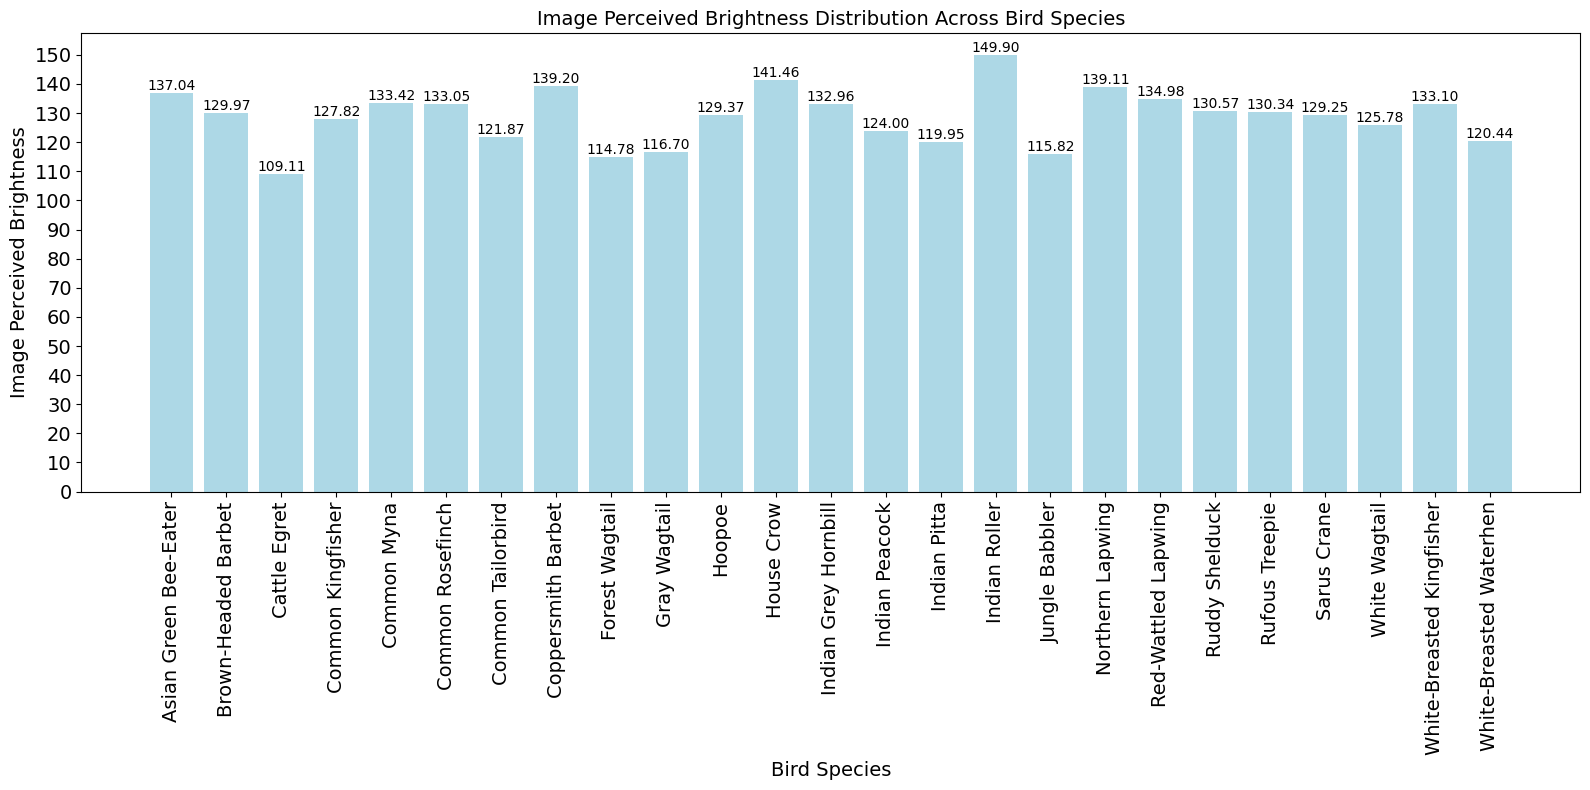

In [24]:
# Analyzing brightness in the images across classes in the dataset
from PIL import Image, ImageStat
import math
import concurrent.futures

# Function to calculate brightness using the weighted sum of RGB channels
def brightness(im_file):
    with Image.open(im_file) as im:
        stat = ImageStat.Stat(im)
        mean = stat.mean
        
        # If the image is grayscale (only one value), use it for all three channels
        if len(mean) == 1:
            r = g = b = mean[0]
        else:
            r, g, b = mean[:3]  # Only unpack the first three values (RGB)

    return math.sqrt(0.241 * (r ** 2) + 0.691 * (g ** 2) + 0.068 * (b ** 2))

# Function to process each image and calculate brightness
def calculate_brightness(image_info):
    class_dir, image_file = image_info
    image_path = os.path.join(dataset_dir, class_dir, image_file)
    
    image_brightness = brightness(image_path)
    
    return {
        'Class': class_dir,
        'Brightness': image_brightness
    }

# Use ThreadPoolExecutor to process images concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    brightness_results = list(executor.map(calculate_brightness, image_list))

# Convert to DataFrame
brightness_df = pd.DataFrame(brightness_results)

# Group by class for summary
brightness_summary = brightness_df.groupby('Class').mean()

# Plot brightness distribution across classes as a bar chart
plt.figure(figsize=(16, 8))

# Plot bars for brightness across classes
x = np.arange(len(brightness_summary.index))  # the label locations
bars = plt.bar(x, brightness_summary['Brightness'], color='lightblue')

# Add labels and title
plt.title('Image Perceived Brightness Distribution Across Bird Species', fontsize =14)
plt.xlabel('Bird Species', fontsize =14)
plt.ylabel('Image Perceived Brightness', fontsize =14)
plt.xticks(x, brightness_summary.index, rotation=90, fontsize =14)

# Add brightness values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (brightness value)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

# Set custom y-ticks from 0 to max brightness with intervals of 10
max_brightness = brightness_summary['Brightness'].max()
plt.yticks(np.arange(0, max_brightness + 10, 10))
plt.yticks(fontsize =14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

So we can see that there is some mild variance in the percieved brightness of images across the classes in the dataset

## Image Property Analysis: Analyzing the contrast distribution in the images across classes in the dataset

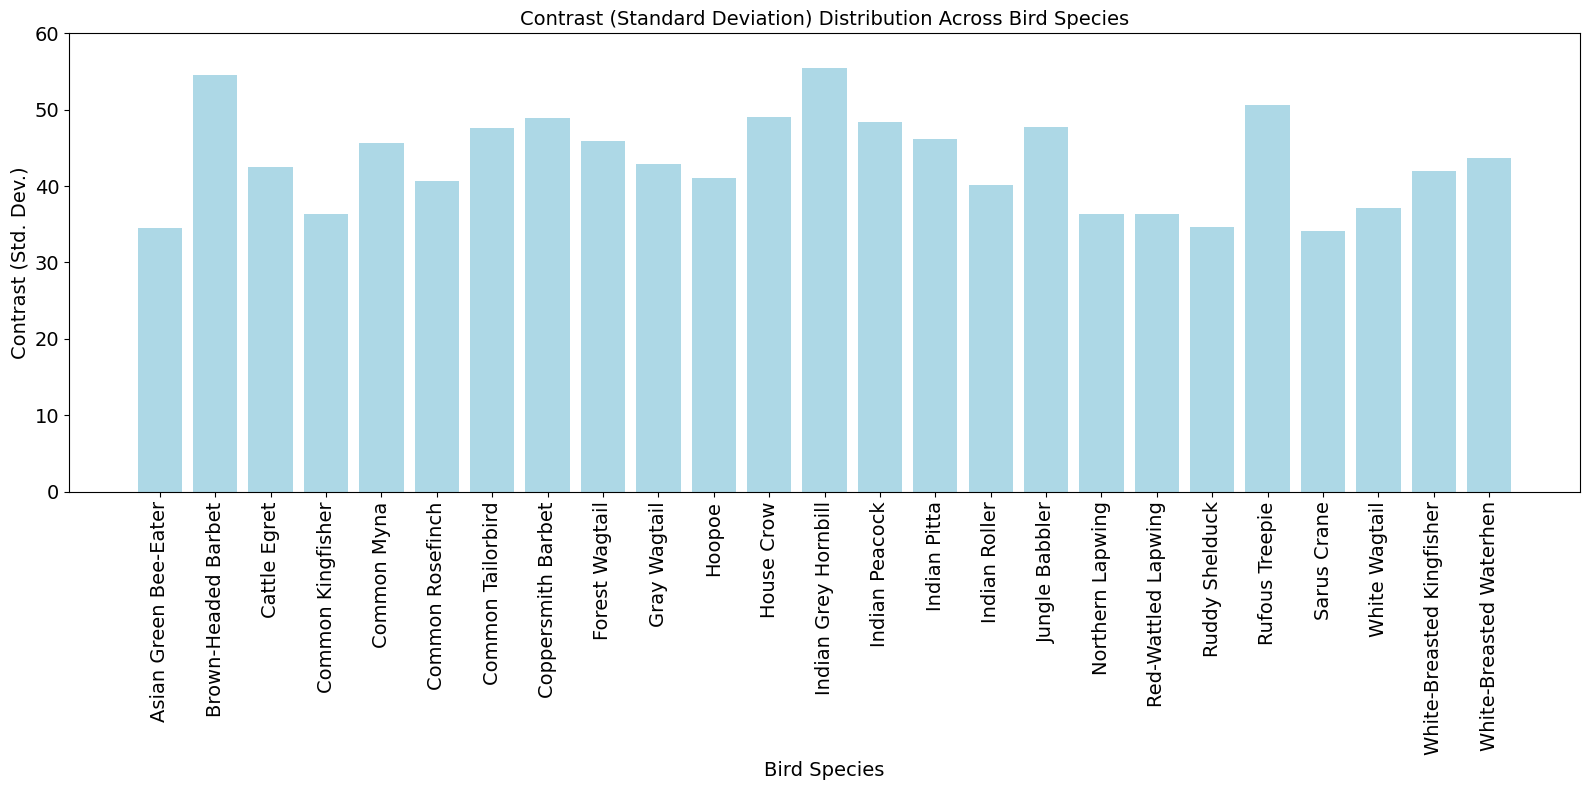

In [25]:
# Analyzing the contrast distribution in the images across classes in the dataset

# Function to calculate contrast using standard deviation of pixel intensity
def contrast_std(im_file):
    with Image.open(im_file) as im:
        # Convert image to grayscale if it's not already
        im_gray = im.convert('L')
        stat = ImageStat.Stat(im_gray)
        return np.std(np.array(im_gray))

# Function to process each image and calculate contrast
def calculate_contrast(image_info):
    class_dir, image_file = image_info
    image_path = os.path.join(dataset_dir, class_dir, image_file)
    
    # Calculate contrast using standard deviation
    image_contrast_std = contrast_std(image_path)
    
    return {
        'Class': class_dir,
        'Contrast_(Std)': image_contrast_std
    }

# Process images concurrently
with ThreadPoolExecutor() as executor:
    contrast_results = list(executor.map(calculate_contrast, image_list))

# Convert to DataFrame
contrast_df = pd.DataFrame(contrast_results)

# Group by class for summary
contrast_summary = contrast_df.groupby('Class').mean()

# Plot contrast distribution across classes as bar chart
plt.figure(figsize=(16, 8))
x = np.arange(len(contrast_summary.index))  # the label locations

# Plot bars for standard deviation contrast across classes
plt.bar(x, contrast_summary['Contrast_(Std)'], color='lightblue')
plt.title('Contrast (Standard Deviation) Distribution Across Bird Species', fontsize = 14)
plt.xlabel('Bird Species', fontsize = 14)
plt.ylabel('Contrast (Std. Dev.)', fontsize = 14)
plt.xticks(x, contrast_summary.index, rotation=90, fontsize = 14)
plt.yticks(np.arange(0, max(contrast_summary['Contrast_(Std)']) + 11, 10))
plt.yticks(fontsize = 14)

plt.tight_layout()
plt.show()

So we can see there is a fair amount of contrast deviation across the image classes 

## Data Cleaning

So from this series of EDA on the dataset we got insights on the image data within it and we decided to remove the identified
1. inconsistant format files : for this we shall use the global variable list - global_inconsistant_files
2. duplicate image files: for this we shall use the global variable list - global_list_for_duplicate
3. blurry image files: for this we shall use globar variable list - blurry_images

To keep original dataset untouched so that the EDA done on it could be reproduced, we make a copy of the dataset namely temp_dataset in  which we shall do the cleaning/removing of the identified image files. Later on we shall use this cleaned dataset 'temp_dataset' to split the data into train, test & validation directories inside the original dataset (named dataset). After the operations, we shall remove the temp_dataset.

In [26]:
# make a copy of dataset called temp_dataset
!cp -r dataset temp_dataset

Let's create a helper function to remove files with paths provided

In [27]:
# helper function to remove files with paths provided
def delete_files_in_temp(file_paths):
    deleted_count = 0  # Counter to keep track of successfully deleted files

    for file_path in file_paths:
        # Replace 'dataset' with 'temp_dataset' in the path
        temp_file_path = file_path.replace('dataset', 'temp_dataset')
        
        # Check if the file exists before deleting
        if os.path.exists(temp_file_path):
            os.remove(temp_file_path)
            deleted_count += 1
        else:
            print(f"File not found: {temp_file_path}")
    
    # Print summary message after completion
    print(f"Successfully deleted {deleted_count} files.")

In [28]:
# removing inconsistant image format files
delete_files_in_temp(global_inconsistant_files)

Successfully deleted 3 files.


In [29]:
# removing duplicate image files
delete_files_in_temp(global_list_for_duplicate)

Successfully deleted 75 files.


In [30]:
# removing low quality/blurry image files
delete_files_in_temp(blurry_images)

Successfully deleted 105 files.


So we see a total of 183 files with inconsistant image format, duplicates and low quality images have been deleted to make the image data quality better before the split into train, test and validation sets.